<font size="6" style="color:#ce4257">AMEX : Building the predictive model</font>
    
<font size="5" style="color:#219ebc">Table of contents</font>

- [Data prepraration](#0)

- [Model implementation](#1)

- [Model training](#2)

- [Feature importances](#3)

In [1]:
%%capture --no-display
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold,train_test_split
from lightgbm import LGBMClassifier,log_evaluation
import warnings
from sklearn import metrics
import shap
import gc
import joblib
from imblearn.over_sampling import RandomOverSampler 

In [2]:
def get_colormap(N:int=20):
    """
        Returns a rgb and hex cyan to pink colormap with the specified number of segmentations.
    """
    rgb_colors = LinearSegmentedColormap.from_list('my_colormap',
                                    ['#bbd5de','#6495ed','#ff355d'],
                                    N=N)
    hex_colors = [rgb2hex(rgb_colors(i)) for i in range(rgb_colors.N)]
    return rgb_colors,hex_colors

In [3]:
TRAIN_CSV = '../input/amaxcompr/train_df_fe.ftr'
SEED = 50

<font size="5" style="color:#219ebc">Data preparation</font>

Lets prepare the data before training, first we need to separate target 'y' from features 'x' and drop the uneeded variable 'customer id' .

In [4]:
train_df = pd.read_feather(TRAIN_CSV)
y = train_df['target_last']
train_df.drop(columns='customer_ID',inplace=True)
x = train_df.loc[:,~train_df.columns.str.startswith('target')]
del train_df
gc.collect()

7

In [6]:
# Split the data into train and test mantaining target proportions.
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, stratify=y, random_state=SEED)
del x,y
gc.collect()

42

<font size="5" style="color:#219ebc">Model implementation</font>

Here we are gonna try the Microsoft boosting based algorithm called lightgbm.

Advantages over Xgboost are :
- low memory usage
- most times performs better
- faster training

We are gonna build a baseline model starting with 1600 estimators and a learning rate of 0.02

In [7]:
model = LGBMClassifier( n_estimators=1600,
                        learning_rate=0.02,
                       random_state=SEED)

<font size="5" style="color:#219ebc">Model training</font>

In [8]:
def custom_metric(y_true: np.array, y_pred: np.array) -> float:
    """
        Computes the competition specific metric based on y_true targets and y_pred predicitons
    """
    
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04
    d = target[four_pct_filter].sum() / n_pos
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))
    g = gini / gini_max
    return 0.5 * (g + d)

def lgb_custom_metric(y_true, y_pred):
    return ('amex',custom_metric(y_true, y_pred),True)

In [9]:
def train(model:LGBMClassifier,x_train:pd.DataFrame,y_train:pd.Series,x_val:pd.DataFrame,y_val:pd.Series,val_metric)->None:
        """
            Fits the specified model
        """
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=UserWarning)
            model.fit(x_train, y_train,
                    eval_set = [(x_val, y_val)], 
                    eval_metric=[val_metric],
                      callbacks=[log_evaluation(100)])
            
train(model,x_train,y_train,x_val,y_val,lgb_custom_metric)
joblib.dump(model,'./lgb.pkl')

[100]	valid_0's binary_logloss: 0.26737	valid_0's amex: 0.756436
[200]	valid_0's binary_logloss: 0.2351	valid_0's amex: 0.771448
[300]	valid_0's binary_logloss: 0.227057	valid_0's amex: 0.777395
[400]	valid_0's binary_logloss: 0.223536	valid_0's amex: 0.782099
[500]	valid_0's binary_logloss: 0.221581	valid_0's amex: 0.784092
[600]	valid_0's binary_logloss: 0.220388	valid_0's amex: 0.786549
[700]	valid_0's binary_logloss: 0.219761	valid_0's amex: 0.788444
[800]	valid_0's binary_logloss: 0.219375	valid_0's amex: 0.788827
[900]	valid_0's binary_logloss: 0.219215	valid_0's amex: 0.789095
[1000]	valid_0's binary_logloss: 0.219084	valid_0's amex: 0.789056
[1100]	valid_0's binary_logloss: 0.21897	valid_0's amex: 0.789769
[1200]	valid_0's binary_logloss: 0.218909	valid_0's amex: 0.789451
[1300]	valid_0's binary_logloss: 0.218814	valid_0's amex: 0.789942
[1400]	valid_0's binary_logloss: 0.218771	valid_0's amex: 0.790086
[1500]	valid_0's binary_logloss: 0.21875	valid_0's amex: 0.790175
[1600]	va

['./lgb.pkl']

<font size="5" style="color:#219ebc">Feature importances</font>

Finally, now that we have trained the model, with the help of the shap library, we are gonna plot the thirty most relevant feature importances.

- The importance of a feature is basically how much a feature is used in each tree of the model. 

- This is useful information to know when we need to explain somehow why the model behaves the way it does.

- Formally, it is computed as the (normalized) total reduction of the criterion brought by that feature.

In [10]:
explainer = shap.TreeExplainer(model, num_iteration=model.best_iteration_)
sample = x_train.sample(10000)
shap_values = explainer.shap_values(sample)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In this graph we see in 4 dimensions
- 1. Y axis shows the feature itself
- 2. X axis show the impact of that features has realative to the target (in this case is the probability of the client defaulting)
- 3. The color gradient shows the magnitude of the feature, with red being the maximum and light blue being the minimum.
- 4. And finally we see the width as a accumulation of points that have affected the prediction in that way (x axis).
<br/><br/>
- We can clearly see that the payment variable P_2_last is negatively correlated and by far the most relevant feature of all.
- A high value of P_2_last (red) has a negative impact in the prediction. This is expected since if the client has high payments records is least likely that it will stop paying.
- Other features seem to have much less impact, and most of them are directly correlated with the prediction.

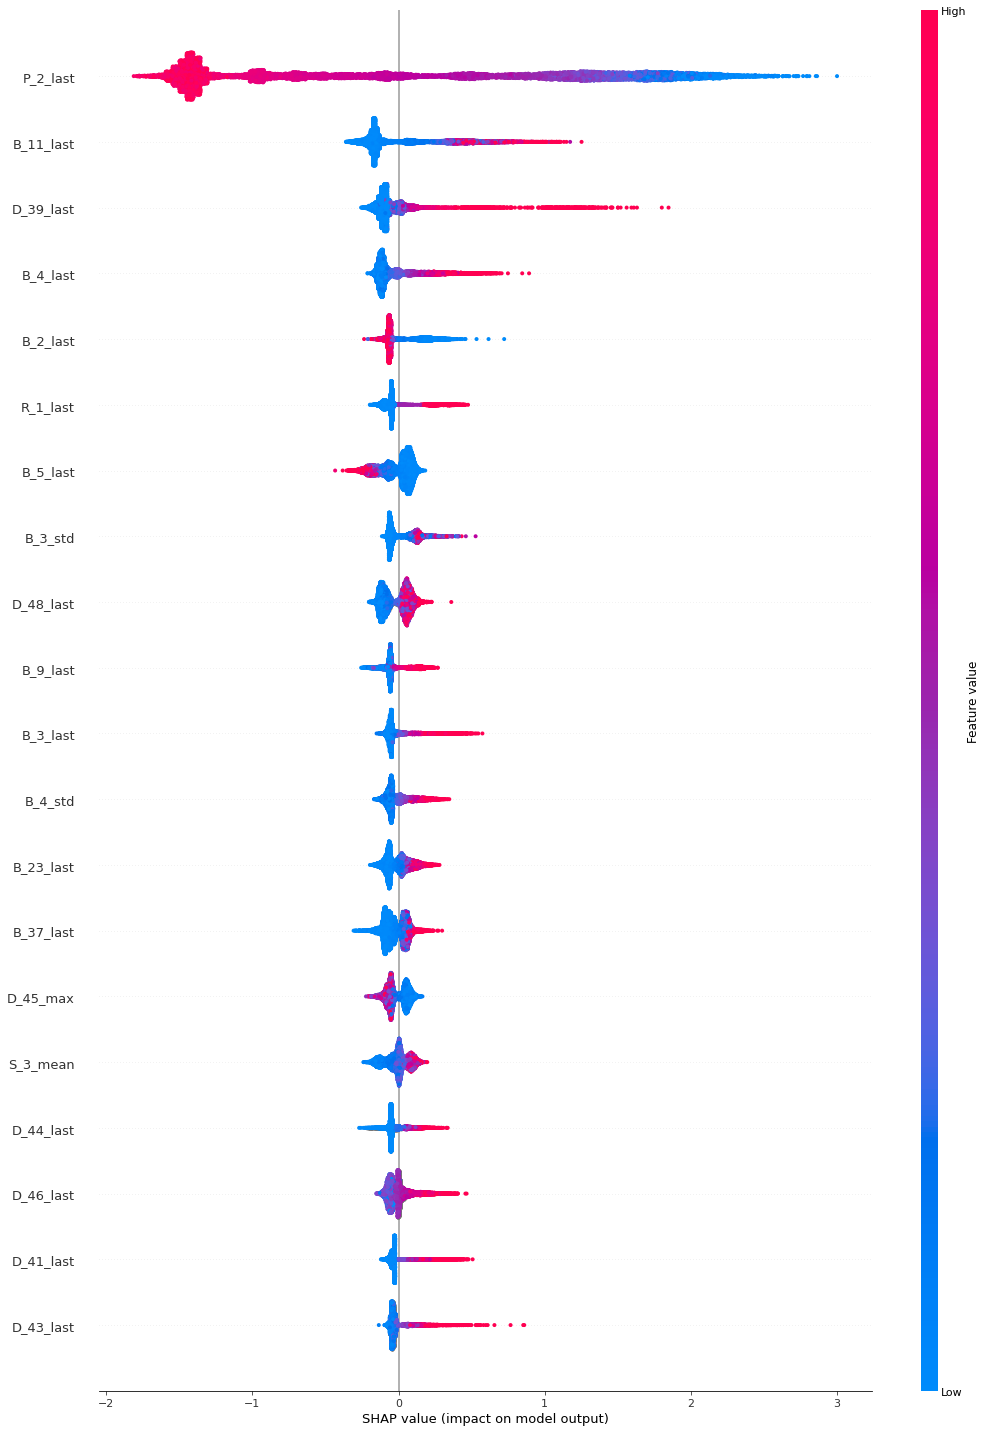

In [11]:
shap.summary_plot(shap_values[1], sample, plot_size = (15,20))